[*********************100%***********************]  10 of 10 completed


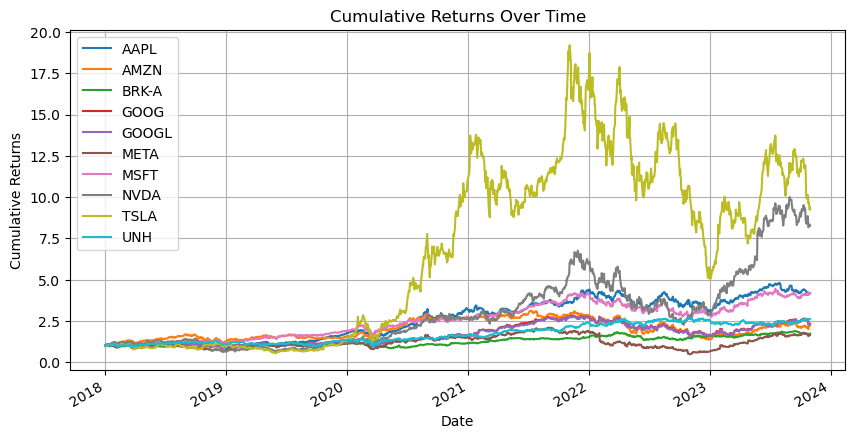

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime

# Define the tickers and the period
tickers = ['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META', 'UNH', 'BRK-A']
start_date = '2018-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')  # Today's date in the format 'YYYY-MM-DD'

# Download the historical data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Plot cumulative returns
cumulative_returns = (daily_returns + 1).cumprod()
cumulative_returns.plot(figsize=(10, 5))
plt.title("Cumulative Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

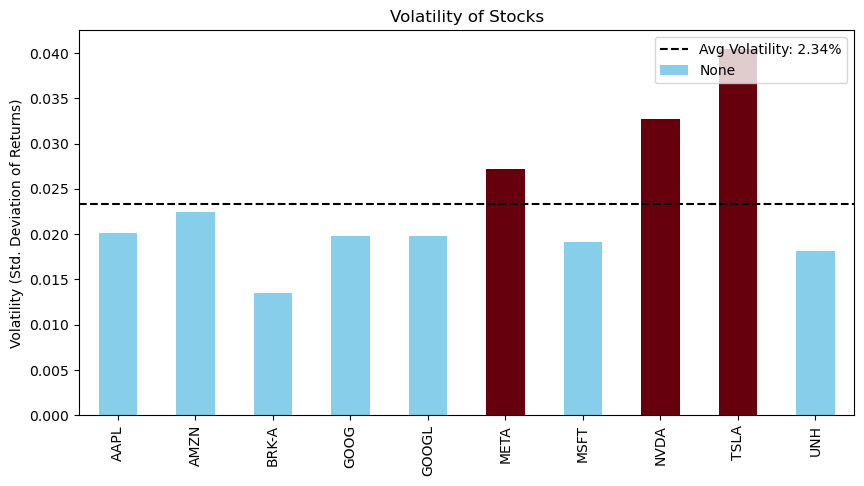

,Total Return,Max Drawdown,Volatility
AAPL,318.79%,-38.52%,2.02%
AMZN,123.87%,-56.15%,2.25%
BRK-A,75.09%,-30.43%,1.36%
GOOG,135.31%,-44.60%,1.98%
GOOGL,131.23%,-44.32%,1.98%
META,66.06%,-76.74%,2.72%
MSFT,320.58%,-37.15%,1.92%
NVDA,726.89%,-66.34%,3.27%
TSLA,839.88%,-73.63%,4.05%
UNH,163.57%,-35.90%,1.82%


In [2]:
import matplotlib.colors as mcolors

# Ensure daily_returns is a DataFrame and not a Series
assert isinstance(daily_returns, pd.DataFrame)

# Plotting volatility
volatility = daily_returns.std()
avg_volatility = volatility.mean()

# Determine the colors based on the gradient scale (blue to red)
colors = [mcolors.to_hex(plt.cm.Reds(vol/avg_volatility)) if vol > avg_volatility else 'skyblue' for vol in volatility]

volatility.plot(kind='bar', figsize=(10, 5), color=colors)
plt.title("Volatility of Stocks")
plt.ylabel("Volatility (Std. Deviation of Returns)")
plt.axhline(y=avg_volatility, color='black', linestyle='--', label=f'Avg Volatility: {avg_volatility:.2%}')
plt.legend(loc='upper right')
plt.show()

# Calculate metrics for the table
total_return = (data.iloc[-1] - data.iloc[0]) / data.iloc[0]
drawdown = (data / data.cummax() - 1).min()

# Construct the table
metrics_df = pd.DataFrame({
    "Total Return": total_return,
    "Max Drawdown": drawdown,
    "Volatility": volatility
})

# Set display format to show values as percentages with two decimal places
pd.set_option('display.float_format', '{:.2%}'.format)

# Print the metrics in the DataFrame
display(metrics_df)

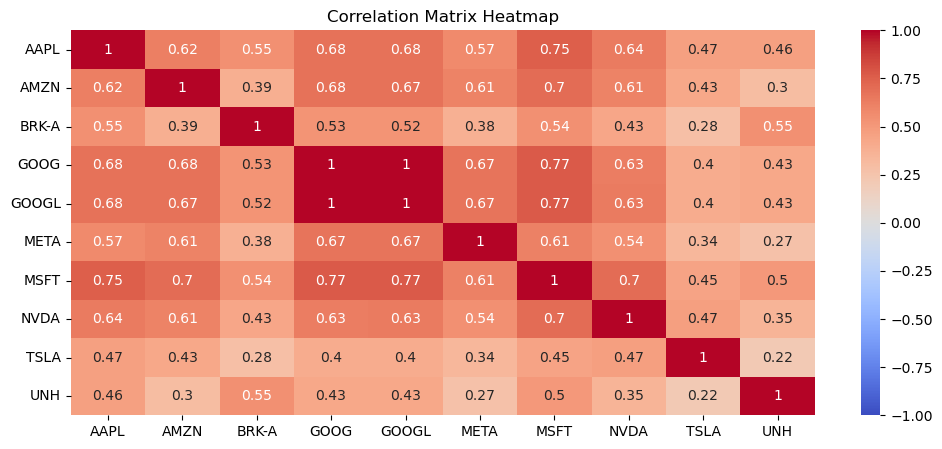

In [3]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = daily_returns.corr()

# Plot the correlation matrix using Seaborn's heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

***Dropped asstes with higher than average volatility and highly correlated assets***

In [4]:
# Define the tickers and the period
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'UNH','BRK-A']
start_date = '2018-01-01'
end_date = end_date

# Download the historical data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate daily returns
returns = data.pct_change()

# Calculate mean returns and covariance of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

[*********************100%***********************]  6 of 6 completed


In [5]:
all_data = [yf.download(ticker, start='2018-01-01', end=end_date) for ticker in tickers]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
stock_data = pd.concat(all_data, axis=1, keys=tickers)

In [7]:
# Define objective function
def objective(weights): 
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return - (portfolio_return - risk_free_rate) / portfolio_stddev

# Parameters

risk_free_rate = 0.048  # example risk-free rate

# Define the quarters
quarters = pd.date_range('2018-01-01', end_date, freq='M')  #innitially tried Quarterly 'Q' but the draw down was too high
                                                                 #more frequent rebalancing is needed to lower the draw down.
# Number of assets
num_assets = len(tickers)

# Initial guess equally distributed among all assets
init_guess = [1./num_assets] * num_assets

# Set bounds for each weight to be between 7.5% (or 0.075) and 22.5%// you can adjust these according to your own risk appetite
bounds = [(0.075, 0.225) for asset in range(num_assets)]

# Constraints: sum of weights is 100% (or 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

quarterly_weights = []

# Iterate over each quarter
for start, end in zip(quarters[:-1], quarters[1:]):
    # Fetch data for this quarter
    data = {}
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start, end=end)
    
    # Calculate returns and covariance matrix for the optimization
    all_data = pd.concat([data[ticker]['Close'] for ticker in tickers], axis=1, keys=tickers)
    returns = all_data.pct_change().dropna()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    # Optimize weights
    #Sequential Least SQuares Programming optimizer. SLSQP minimizes a function of several variables with any combination of 
    #bounds, equality and inequality constraints.
    solution = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    weights = solution.x
    quarterly_weights.append(weights)

# Convert weights to DataFrame and display
weights_df = pd.DataFrame(quarterly_weights, columns=tickers, index=quarters[1:])
display(weights_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,AAPL,MSFT,GOOG,AMZN,UNH,BRK-A
2018-02-28,22.50%,22.50%,7.50%,22.50%,17.50%,7.50%
2018-03-31,7.50%,22.50%,17.50%,22.50%,7.50%,22.50%
2018-04-30,7.50%,22.50%,7.50%,22.50%,22.50%,17.50%
2018-05-31,22.50%,22.50%,7.50%,21.06%,18.94%,7.50%
2018-06-30,7.50%,17.50%,22.50%,22.50%,22.50%,7.50%
...,...,...,...,...,...,...
2023-06-30,22.50%,17.50%,7.50%,22.50%,7.50%,22.50%
2023-07-31,17.50%,7.50%,22.50%,7.50%,22.50%,22.50%
2023-08-31,7.50%,17.50%,22.50%,22.50%,7.50%,22.50%
2023-09-30,7.50%,22.50%,22.50%,17.50%,22.50%,7.50%


In [8]:
# Set display format to show values as percentages with two decimal places
pd.set_option('display.float_format', '{:.2%}'.format)

# Print the weights in the DataFrame
display(weights_df) 

,AAPL,MSFT,GOOG,AMZN,UNH,BRK-A
2018-02-28,22.50%,22.50%,7.50%,22.50%,17.50%,7.50%
2018-03-31,7.50%,22.50%,17.50%,22.50%,7.50%,22.50%
2018-04-30,7.50%,22.50%,7.50%,22.50%,22.50%,17.50%
2018-05-31,22.50%,22.50%,7.50%,21.06%,18.94%,7.50%
2018-06-30,7.50%,17.50%,22.50%,22.50%,22.50%,7.50%
...,...,...,...,...,...,...
2023-06-30,22.50%,17.50%,7.50%,22.50%,7.50%,22.50%
2023-07-31,17.50%,7.50%,22.50%,7.50%,22.50%,22.50%
2023-08-31,7.50%,17.50%,22.50%,22.50%,7.50%,22.50%
2023-09-30,7.50%,22.50%,22.50%,17.50%,22.50%,7.50%


C:\Users\nxity\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\nxity\AppData\Local\Temp\ipykernel_27960\363576586.py:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio_returns = pd.Series(index=all_data_returns.index)
C:\Users\nxity\anaconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2018-02-28
End date,2023-10-30
Total months,68
,Backtest
Annual return,17.7%
Cumulative returns,151.8%
Annual volatility,24.2%
Sharpe ratio,0.80
Calmar ratio,0.66
Stability,0.86
Max drawdown,-26.9%


C:\Users\nxity\anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


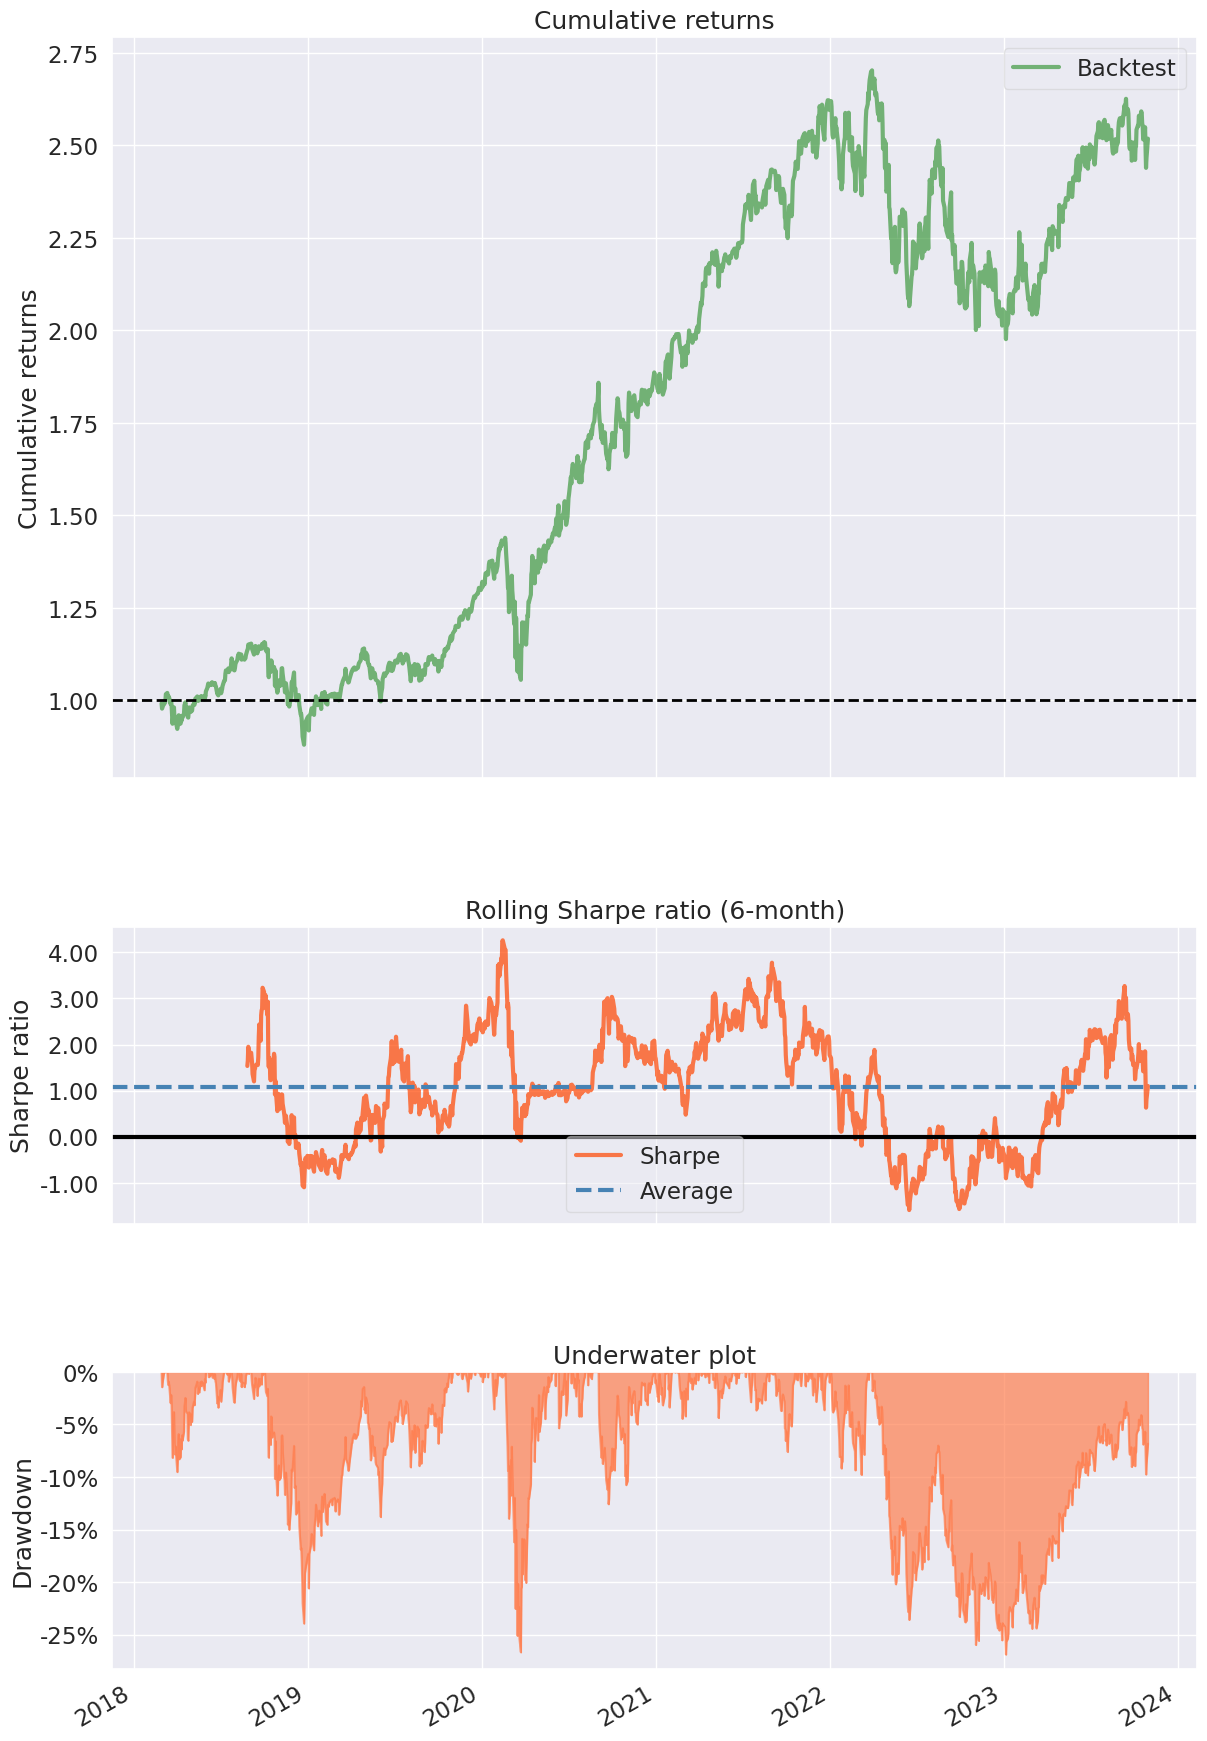

In [9]:
import yfinance as yf
import pyfolio as pf

# Define tickers and fetch data as before
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start='2018-01-01', end= end_date)['Adj Close']

all_data = pd.concat([data[ticker] for ticker in tickers], axis=1, keys=tickers)
all_data_returns = all_data.pct_change().dropna()

# Create an empty series to hold our portfolio returns
portfolio_returns = pd.Series(index=all_data_returns.index)

# For each quarter, populate our portfolio returns based on the given weights
for start_date, weights in weights_df.iterrows():
    if start_date == weights_df.index[-1]:  # If it's the last date in the index
        end_date = all_data_returns.index[-1]
    else:
        end_date = weights_df.index[weights_df.index.get_loc(start_date) + 1]
    
    mask = (all_data_returns.index >= start_date) & (all_data_returns.index < end_date)
    for date, daily_returns in all_data_returns[mask].iterrows():
        portfolio_returns.loc[date] = daily_returns.dot(weights)

portfolio_returns = portfolio_returns.dropna()

# Analyze with pyfolio
pf.create_simple_tear_sheet(portfolio_returns)

[*********************100%***********************]  1 of 1 completed
Strategy Total Return: 151.83%
S&P 500 (BM) Total Return: 54.57%


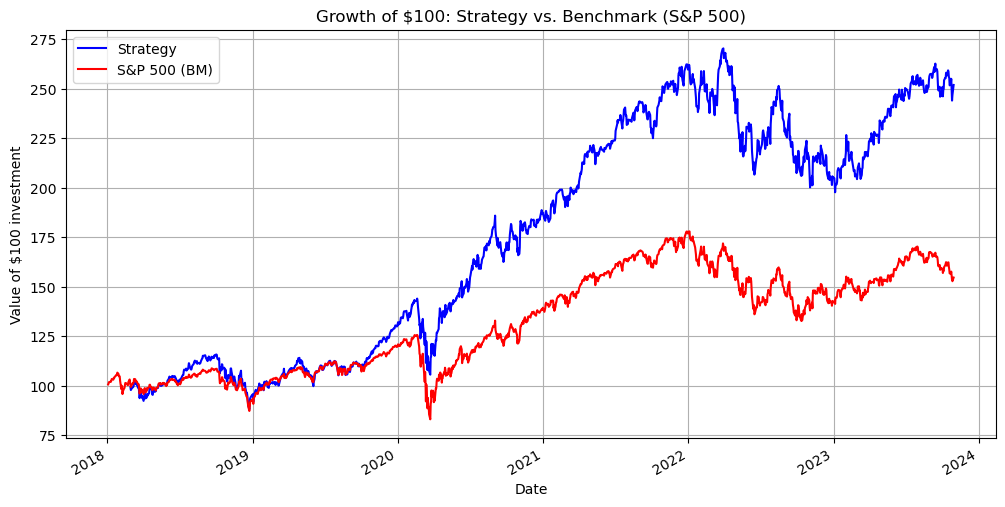

In [10]:
import yfinance as yf
import matplotlib.pyplot as plt

# Download S&P 500 index data for the same period as the benchmark
benchmark_data = yf.download('^GSPC', start='2018-01-01', end= end_date)['Adj Close']

# Calculate daily returns for the benchmark
benchmark_returns = benchmark_data.pct_change().dropna()

# Compute the growth of $100 investment
initial_investment = 100
portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()
benchmark_value = initial_investment * (1 + benchmark_returns).cumprod()

# Calculate total returns
strategy_return = (portfolio_value.iloc[-1] - initial_investment) / initial_investment * 100
benchmark_return = (benchmark_value.iloc[-1] - initial_investment) / initial_investment * 100

# Print the returns
print(f"Strategy Total Return: {strategy_return:.2f}%")
print(f"S&P 500 (BM) Total Return: {benchmark_return:.2f}%")

# Plot the growth of $100 investment
plt.figure(figsize=(12, 6))
portfolio_value.plot(label="Strategy", color='blue')
benchmark_value.plot(label="S&P 500 (BM)", color='red')
plt.title("Growth of $100: Strategy vs. Benchmark (S&P 500)")
plt.xlabel("Date")
plt.ylabel("Value of $100 investment")
plt.legend()
plt.grid(True)
plt.show()

***Monthly Rebalancing***

C:\Users\nxity\anaconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2018-02-28
End date,2023-10-30
Total months,68
,Backtest
Annual return,17.7%
Cumulative returns,151.8%
Annual volatility,24.2%
Sharpe ratio,0.80
Calmar ratio,0.66
Stability,0.86
Max drawdown,-26.9%


C:\Users\nxity\anaconda3\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


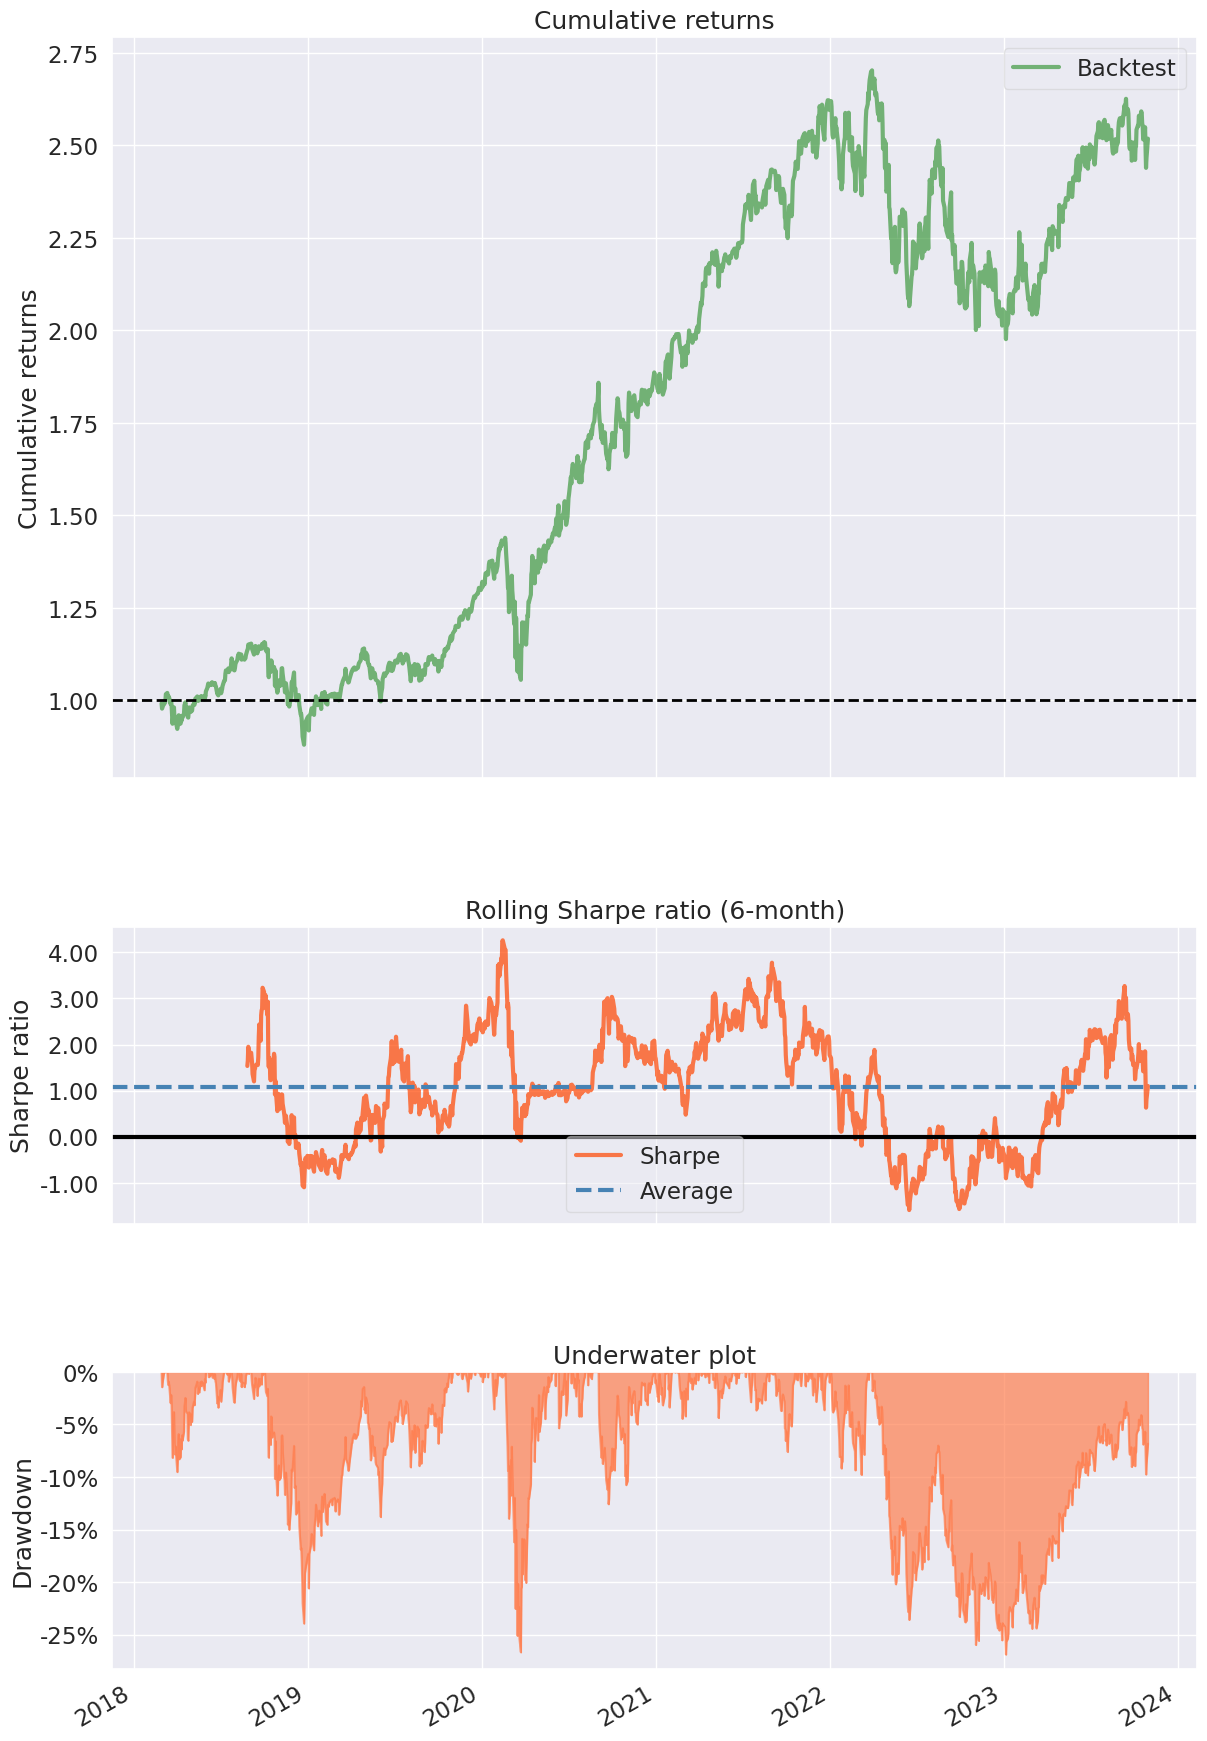

In [11]:
# Analyze with pyfolio
pf.create_simple_tear_sheet(portfolio_returns)